In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.decomposition import PCA
from typing import List

types = ["kbase", "vbase", "q", "k", "v", "latents"]
rank = 1
layer = 25
steps = list(range(28))

def load_err_data(data_file_path):
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"The file {data_file_path} does not exist.")
    print(f"Loading data from {data_file_path}")
    data = torch.load(data_file_path)
    return data

def load_pca_data(root_path: str, type: str):
    if type not in types:
        raise ValueError(f"Invalid type: {type}. Must be one of {types}.")
    
    data = []
    for step in steps:
        data_file_path = os.path.join(
            root_path,
            f"{step}_{type}.pt"
        )
        data.append(torch.load(data_file_path).numpy().flatten())
    data = np.array(data)
    return data

marker = {
    'Original': 'o',
    'Naive Compression': '^',
    'Without ErrorFeedback': 's',
    'With ErrorFeedback': '*',
    'Compression': 'o'
}
sustech_orange = '#ed6c00'
sustech_darkgreen = '#003f43'
sustech_lightgreen = '#2bb7b3'

color = {
    'Original': sustech_lightgreen,
    'Naive Compression': sustech_darkgreen,
    'Without ErrorFeedback': sustech_darkgreen,
    'With ErrorFeedback': sustech_darkgreen,
    'Compression': sustech_darkgreen
}

steps_comp_color = sustech_darkgreen
steps_total_color = sustech_orange

In [2]:
def plot_err_line(data, ax, min: int=0, max: int=2000):
    steps = data['steps']
    steps = [s + 2 for s in steps]
    avg_comp_err = data['avg_comp_errors']
    avg_total_err = data['avg_total_errors']
    plot_steps_comp = [s for s, e in zip(steps, avg_comp_err) if e is not None]
    plot_errors_comp = [e for e in avg_comp_err if e is not None]
    plot_steps_total = [s for s, e in zip(steps, avg_total_err) if e is not None]
    plot_errors_total = [e for e in avg_total_err if e is not None]
    ax.plot(plot_steps_comp, plot_errors_comp, label='Component Error', color=steps_comp_color)
    ax.plot(plot_steps_total, plot_errors_total, label='Total Error', color=steps_total_color)
    ax.set_xlabel('Steps')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=min, top=max)
    ax.grid(True, alpha=0.3)
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.tick_params(axis='y', which='both', left=False, right=False, rotation=90)

def plot_pca_line(pca_data_original, pca_data_comparison, comparison_label, ax):
    # Plot scatter points
    ax.scatter(pca_data_original[:, 0], pca_data_original[:, 1], c=color['Original'], marker='o', label='Original', s=10)
    ax.scatter(pca_data_comparison[:, 0], pca_data_comparison[:, 1], c=color[comparison_label], marker=marker[comparison_label], label=comparison_label, s=10)
    # Plot lines with arrows between points
    for i in range(len(pca_data_original)-1):
        # Original data arrows
        ax.annotate('', 
                   xy=(pca_data_original[i+1, 0], pca_data_original[i+1, 1]),
                   xytext=(pca_data_original[i, 0], pca_data_original[i, 1]),
                   arrowprops=dict(arrowstyle='->', color=color['Original'], alpha=0.5))
        
        # Comparison data arrows
        ax.annotate('',
                   xy=(pca_data_comparison[i+1, 0], pca_data_comparison[i+1, 1]),
                   xytext=(pca_data_comparison[i, 0], pca_data_comparison[i, 1]),
                   arrowprops=dict(arrowstyle='->', color=color[comparison_label], alpha=0.5))
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(bottom=-1600, top=1600)

Loading data from avg_err_dump/average_error_vs_steps_naive.pt
Loading data from avg_err_dump/average_error_vs_steps_residual.pt
Loading data from avg_err_dump/average_error_vs_steps_ef.pt


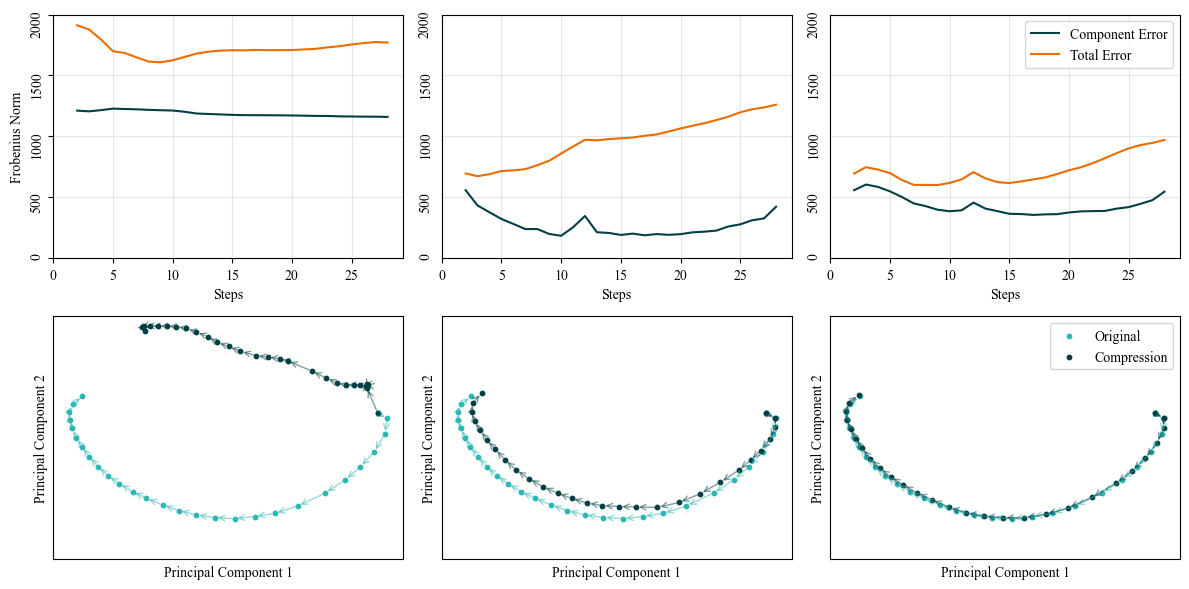

In [3]:
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman']

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

naive_err = "avg_err_dump/average_error_vs_steps_naive.pt"
wo_ef_err = "avg_err_dump/average_error_vs_steps_residual.pt"
w_ef_err = "avg_err_dump/average_error_vs_steps_ef.pt"
naive_err_data = load_err_data(naive_err)
wo_ef_data = load_err_data(wo_ef_err)
w_ef_data = load_err_data(w_ef_err)

original_pca = "pca_activation/original"
naive_pca = "pca_activation/naive"
wo_ef_pca = "pca_activation/wo_ef"
w_ef_pca = "pca_activation/w_ef"
original_pca_data = load_pca_data(original_pca, 'k')
naive_pca_data = load_pca_data(naive_pca, 'k')
wo_ef_pca_data = load_pca_data(wo_ef_pca, 'k')
w_ef_pca_data = load_pca_data(w_ef_pca, 'k')

combined_data = np.vstack([original_pca_data, naive_pca_data, wo_ef_pca_data, w_ef_pca_data])
pca = PCA(n_components=2)
pca.fit(combined_data)
original_pca_transformed = pca.transform(original_pca_data)
naive_pca_transformed = pca.transform(naive_pca_data)
wo_ef_pca_transformed = pca.transform(wo_ef_pca_data)
w_ef_pca_transformed = pca.transform(w_ef_pca_data)

plot_err_line(naive_err_data, axes[0, 0])
plot_err_line(wo_ef_data, axes[0, 1])
plot_err_line(w_ef_data, axes[0, 2])

plot_pca_line(original_pca_transformed, naive_pca_transformed, 'Compression', axes[1, 0])
plot_pca_line(original_pca_transformed, wo_ef_pca_transformed, 'Compression', axes[1, 1])
plot_pca_line(original_pca_transformed, w_ef_pca_transformed, 'Compression', axes[1, 2])

axes[0, 0].set_ylabel("Frobenius Norm")
axes[0, 0].tick_params(axis='y', which='both', left=True, right=False)
axes[0, 2].legend(loc='upper right', bbox_to_anchor=(1, 1))
axes[1, 2].legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()